Tutorial on YouTube Chanel:
Text Visualization | Lecture 2 | CPE 393 Text Analytics
https://www.youtube.com/watch?v=rAQCQKnkNh0&t=774s

##### <b>Load Dataset</b>

In [26]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [6]:
df = pd.read_csv('un-general-debates.csv')
df.sample(5)

,session,year,country,text
5799,32,1977,HTI,"﻿313.\t Mr. President, I have the honour on be..."
6573,28,1973,IRN,﻿164.\tThe election to the high office of Pres...
2163,43,1988,IRL,﻿\nI should like first to offer Mr. Dante Capu...
142,44,1989,PAN,"﻿\nMr. President, on behalf of the delegation ..."
4417,58,2003,BRN,"﻿My congratulations go to you, Sir, and to the..."


In [5]:
df.count()

session    7507
year       7507
country    7507
text       7507
dtype: int64

In [8]:
# Primary key

df[['session', 'country']].drop_duplicates().count()

session    7507
country    7507
dtype: int64

##### <b>DataFrame Summary Statistics</b>

In [10]:
df['length'] = df['text'].str.len()

In [11]:
df.columns

Index(['session', 'year', 'country', 'text', 'length'], dtype='object')

In [13]:
df.dtypes

session     int64
year        int64
country    object
text       object
length      int64
dtype: object

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
 4   length   7507 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 293.4+ KB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [19]:
df[['country']].describe(include='O').T

,count,unique,top,freq
country,7507,199,IRN,46


##### <b>Check Missing Data</b>

In [20]:
df.isna().sum()

session    0
year       0
country    0
text       0
length     0
dtype: int64

##### <b>Plotting distribution</b>

<AxesSubplot:>

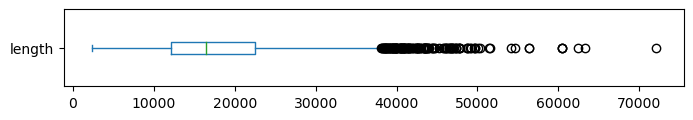

In [27]:
df['length'].plot(kind='box', vert=False, figsize=(8,1))

AttributeError: 'Rectangle' object has no property 'bin'

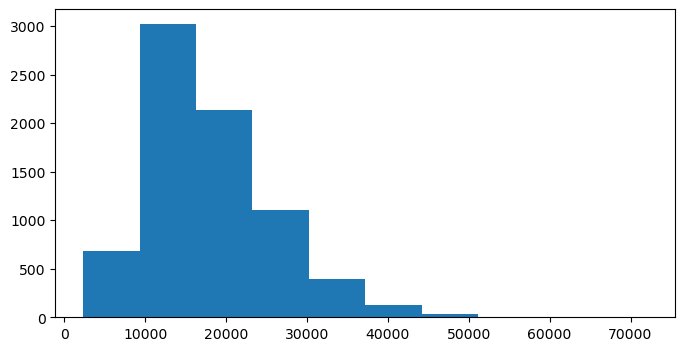

In [29]:
df['length'].plot(kind='hist', bin=30, figsize=(8,4), edgecolor='k')